# Load dataset

In [ ]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!unzip mushroom.zip

Archive:  mushroom.zip
replace Index? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
TRAIN_FILENAME = "agaricus-lepiota.data"

df = pd.read_table(TRAIN_FILENAME, sep=',', header=None)
target_col = 0

df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [ ]:
df.describe(include='all')

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


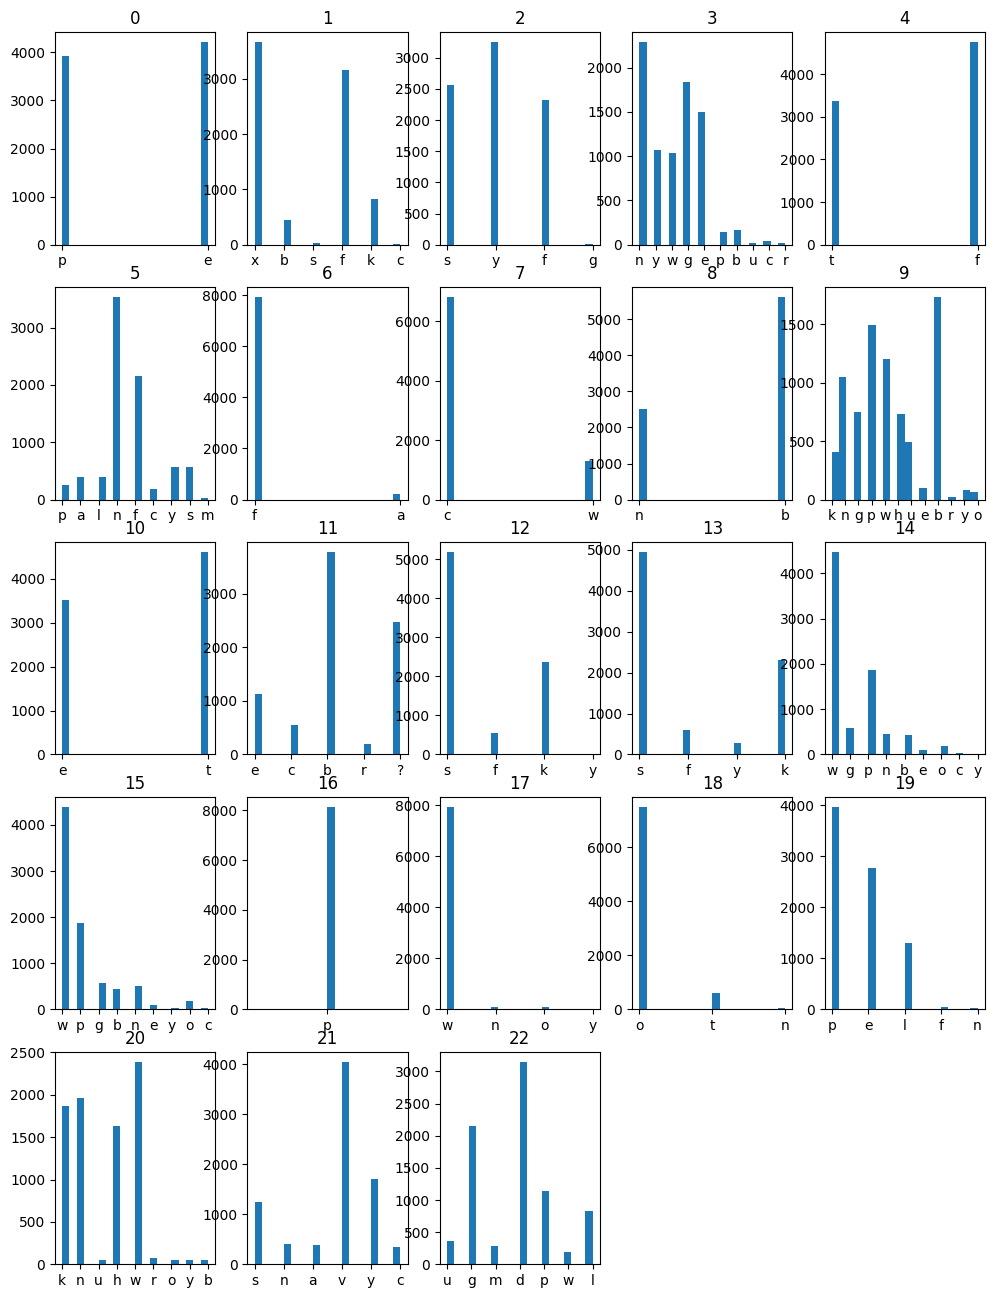

In [ ]:
plt.figure(figsize=(12, 16))
cols = df.columns
plt_size = int(np.sqrt(len(cols) - 1)) + 1

for i, col in enumerate(cols):
    plt.subplot(plt_size, int((len(cols) - 1) / plt_size) + 1, i + 1)
    plt.title(col)
    plt.hist(df[col], bins=20)

# Prepare

In [ ]:
df[df == '?'] = np.nan

In [ ]:
df.isna().sum()

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11    2480
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
dtype: int64

In [ ]:
# Replace with mode

for col in df.columns:
    df[col][df[col] == np.nan] = df[col].mode()

In [ ]:
from sklearn.preprocessing import LabelEncoder

col_enc = {}

for col in df.columns:
    col_enc[col] = LabelEncoder()
    df[col] = col_enc[col].fit_transform(df[col])

df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [ ]:
def train_test_split(data, labels, train_size=0.8, shuffle=True, random_state=None):
    assert data.shape[0] == labels.shape[0]

    sz = data.shape[0]

    if shuffle:
        perm = np.random.default_rng(seed=random_state).permutation(sz)
        data = data[perm]
        labels = labels[perm]

    if 0 < train_size < 1:
        train_size = int(train_size * sz)

    return data[:train_size], data[train_size:], labels[:train_size], labels[train_size:]

# Train

In [ ]:
class Node():
    def __init__(self, feature=None, thresholds=None, children=None,
                 gain=None, value=None):
        """
        Args:
            feature: The feature used for splitting at this node
            thresholds: The threshold used for splitting at this node
            children: Node children
            gain: The gain of the split
            value: If this node is a leaf node, this attribute represents the predicted value
                for the target variable
        """

        self.feature = feature
        self.thresholds = thresholds
        self.children = children
        self.gain = gain
        self.value = value

In [ ]:
class DecisionTree():
    def __init__(self, min_samples=2, max_depth=2):
        """
        Args:
            min_samples (int): Minimum number of samples required to split an internal node.
            max_depth (int): Maximum depth of the decision tree.
        """
        self.min_samples = min_samples
        self.max_depth = max_depth

    def split_data(self, dataset, feature, thresholds):
        """
        Splits the given dataset into two datasets based on the given feature and threshold.

        Parameters:
            dataset (ndarray): Input dataset.
            feature (int): Index of the feature to be split on.

        Returns:
            left_dataset (ndarray): Subset of the dataset with values less than or equal to the threshold.
            right_dataset (ndarray): Subset of the dataset with values greater than the threshold.
        """


        datasets = []

        for threshold in thresholds:
            datasets.append(dataset[dataset[:, feature] == threshold])

        return datasets

    def entropy(self, y):
        """
        Computes the entropy of the given label values.

        Parameters:
            y (ndarray): Input label values.

        Returns:
            entropy (float): Entropy of the given label values.
        """

        entropy = 0

        labels = np.unique(y)
        for label in labels:
            pl = len(y[y == label]) / len(y)

            # Calculate the entropy
            entropy += -pl * np.log2(pl)

        return entropy

    def information_gain(self, parent, children):
        """
        Computes the information gain from splitting the parent dataset into two datasets.

        Parameters:
            parent (ndarray): Input parent dataset.
            left (ndarray): Subset of the parent dataset after split on a feature.
            right (ndarray): Subset of the parent dataset after split on a feature.

        Returns:
            information_gain (float): Information gain of the split.
        """

        parent_entropy = self.entropy(parent)
        weighted_entropy = 0

        for child in children:
            weight = len(child) / len(parent)
            weighted_entropy += weight * self.entropy(child)

        return parent_entropy - weighted_entropy

    def best_split(self, dataset):
        """
        Finds the best split for the given dataset.

        Args:
            dataset (ndarray): The dataset to split.

        Returns:
            dict: A dictionary with the best split feature index, threshold, gain,
                left and right datasets.
        """

        num_samples, num_features = dataset.shape[0], dataset.shape[1] - 1

        best_split = {'gain':- 1, 'feature': None, 'threshold': None}

        for feature_index in range(num_features):
            thresholds = sorted(np.unique(dataset[:, feature_index]))
            children = self.split_data(dataset, feature_index, thresholds)

            if len(children) < 2:
                continue

            children_y = [child[:, -1] for child in children]

            information_gain = self.information_gain(dataset[:, -1], children_y)

            if information_gain > best_split["gain"]:
                best_split["feature"] = feature_index
                best_split['thresholds'] = thresholds
                best_split["children"] = children
                best_split["gain"] = information_gain

        return best_split

    def calculate_leaf_value(self, y):
        # The most occurring value in the list.
        return len(y[y == 1]) / len(y)

    def build_tree(self, dataset, current_depth=0):
        """
        Recursively builds a decision tree from the given dataset.

        Args:
            dataset (ndarray): The dataset to build the tree from.
            current_depth (int): The current depth of the tree.

        Returns:
            Node: The root node of the built decision tree.
        """
        # split the dataset into X, y values
        X, y = dataset[:, :-1], dataset[:, -1]

        # keeps spliting until stopping conditions are met
        if X.shape[0] >= self.min_samples and current_depth <= self.max_depth:
            best_split = self.best_split(dataset)

            if best_split["gain"] > 0:
                children_nodes = []

                for child_dataset in best_split['children']:
                    next_node = self.build_tree(child_dataset, current_depth + 1)
                    children_nodes.append(next_node)

                return Node(
                    best_split["feature"], best_split["thresholds"],
                    children_nodes, best_split["gain"]
                )

        # compute leaf node value
        leaf_value = self.calculate_leaf_value(y)
        return Node(value=leaf_value)

    def fit(self, X, y):
        """
        Args:
            X (ndarray): The feature matrix.
            y (ndarray): The target values.
        """
        dataset = np.concatenate((X, np.expand_dims(y, axis=-1)), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):
        """
        Args:
            X (ndarray): The feature matrix to make predictions for.
        Returns:
            ndarray: A list of predicted class labels.
        """

        predictions = [self.make_prediction(x, self.root) for x in X]

        return np.array(predictions)

    def make_prediction(self, x, node):
        """
        Traverses the decision tree to predict the target value for the given feature vector.

        Args:
            x (ndarray): The feature vector to predict the target value for.
            node (Node): The current node being evaluated.
        Returns:
            The predicted target value for the given feature vector.
        """

        if node.value != None:
            return node.value

        for i, threshold in enumerate(node.thresholds):
            if x[node.feature] == threshold:
                return self.make_prediction(x, node.children[i])

        return self.make_prediction(x, np.random.choice(node.children))

In [ ]:
class Metrics:
    @staticmethod
    def confusion_matrix(y_true, y_pred, threshold: float = 0.5):
        """
        Computes the confusion matrix of a classification model.

        Args:
            y_true (numpy array): A numpy array of true labels for each data point.
            y_pred (numpy array): A numpy array of predictions for each data point.
            threshold (float): threshold for cosidering prediction class
        Returns:
            ndarray: Confusion matrix 2x2
        """

        if isinstance(y_true, pd.Series):
            y_true = y_true.to_numpy().flatten()
        if isinstance(y_pred, pd.Series):
            y_pred = y_pred.to_numpy().flatten()

        matrix = [
            [
                np.sum(y_pred[y_true == 0] < threshold), # True Negative
                np.sum(y_pred[y_true == 0] >= threshold)  # False Poitive
            ],
            [
                np.sum(y_pred[y_true == 1] < threshold), # False Negative
                np.sum(y_pred[y_true == 1] >= threshold)  # True Positive
            ]
        ]

        return np.array(matrix)

    @staticmethod
    def accuracy(y_true, y_pred, threshold: float = 0.5):
        c_m = Metrics.confusion_matrix(y_true, y_pred, threshold)
        return (c_m[0, 0] + c_m[1, 1]) / np.sum(c_m)

    @staticmethod
    def percision(y_true, y_pred, threshold: float = 0.5):
        c_m = Metrics.confusion_matrix(y_true, y_pred, threshold)
        return c_m[1, 1] / (c_m[1, 1] + c_m[0, 1]) # TP / (TP + FP)

    @staticmethod
    def recall(y_true, y_pred, threshold: float = 0.5):
        c_m = Metrics.confusion_matrix(y_true, y_pred, threshold)
        return c_m[1, 1] / (c_m[1, 1] + c_m[1, 0]) # TP / (TP + FN)

    @staticmethod
    def fp_rate(y_true, y_pred, threshold: float = 0.5):
        c_m = Metrics.confusion_matrix(y_true, y_pred, threshold)
        return c_m[0, 1] / (c_m[0, 0] + c_m[0, 1]) # FP / (TN + FP)

    @staticmethod
    def f1_score(y_true, y_pred, threshold: float = 0.5):
        p = Metrics.percision(y_true, y_pred, threshold)
        r = Metrics.recall(y_true, y_pred, threshold)
        return 2 * p * r / (p + r)

In [ ]:
class Graphs:
    thresholds = np.linspace(0, 1, 21)

    @staticmethod
    def heatmap(y_true, y_pred):
        sns.heatmap(Metrics.confusion_matrix(y_true, y_pred), annot=True, fmt="g")
        plt.show()

    @staticmethod
    def auc_roc(y_true, y_pred):
        tpr, fpr = [], []

        for threshold in Graphs.thresholds:
            tpr.append(Metrics.recall(y_true, y_pred, threshold))
            fpr.append(Metrics.fp_rate(y_true, y_pred, threshold))

        fpr_array = [[tpr[i], tpr[i+1]] for i in range(len(tpr) - 1)]
        tpr_array = [[fpr[i], fpr[i+1]] for i in range(len(fpr) - 1)]

        auc = sum(np.trapz(tpr_array,fpr_array)) + 1
        print('Area under curve={}'.format(auc))

        plt.plot(tpr_array, fpr_array, 'r', lw=2)
        plt.plot([0, 1], [0, 1], 'k-', lw=2)
        plt.xlabel('FP Rate')
        plt.ylabel('TP Rate')
        plt.title(f'AUC-ROC curve (AUC={round(auc,3)})')
        plt.show()

    def auc_pr(y_true, y_pred):
        rec, per = [], []

        for threshold in Graphs.thresholds:
            rec.append(Metrics.recall(y_true, y_pred, threshold))
            per.append(Metrics.percision(y_true, y_pred, threshold))

        rec_array = [[rec[i], rec[i+1]] for i in range(len(rec) - 1)]
        per_array = [[per[i], per[i+1]] for i in range(len(per) - 1)]

        auc = sum(np.trapz(per_array, rec_array)) + 1
        print('Area under curve={}'.format(auc))

        plt.plot(per_array, rec_array, 'r', lw=2)
        plt.xlabel('Recall')
        plt.ylabel('Percision')
        plt.title(f'AUC-PR curve (AUC={round(auc,3)})')
        plt.show()

In [ ]:
def eval_model(data, labels, features: list[int], min_samples: int = 2, max_depth: int = 2):
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
    if isinstance(labels, pd.DataFrame):
        labels = labels.to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=11)

    print(f"Train Decision Tree with args: min_samples = {min_samples}, max_depth = {max_depth}")

    decision_tree = DecisionTree(min_samples=min_samples, max_depth=max_depth)
    decision_tree.fit(X_train[:, features], y_train)

    predictions = decision_tree.predict(X_test[:, features])

    print(f"Model accuracy: {Metrics.accuracy(y_test, predictions):.4f}")
    print(f"Model recall: {Metrics.recall(y_test, predictions):.4f}")
    print(f"Model percision: {Metrics.percision(y_test, predictions):.4f}")
    print(f"Model F1: {Metrics.f1_score(y_test, predictions):.4f}")

    Graphs.heatmap(y_test, predictions)
    Graphs.auc_roc(y_test, predictions)
    Graphs.auc_pr(y_test, predictions)

    return decision_tree, Metrics.f1_score(y_test, predictions)

Use features to train: [5, 8, 11, 20, 21]
Train Decision Tree with args: min_samples = 2, max_depth = 2
Model accuracy: 0.9502
Model recall: 0.9022
Model percision: 0.9929
Model F1: 0.9454


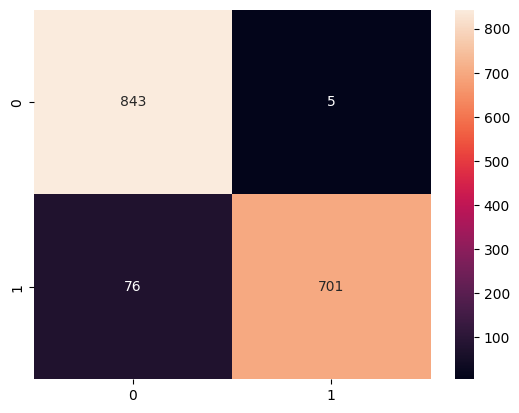

Area under curve=0.9917839841188898


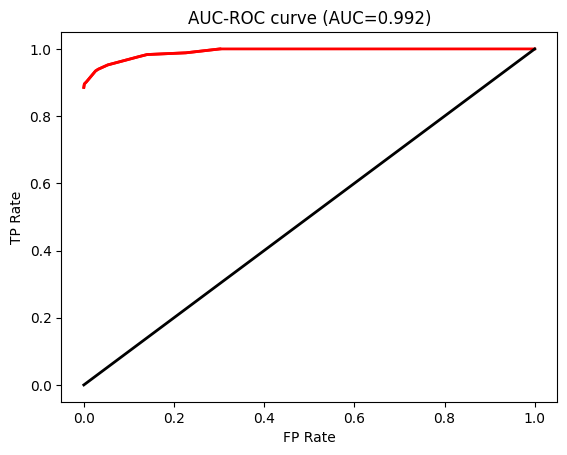

Area under curve=0.8932798416108948


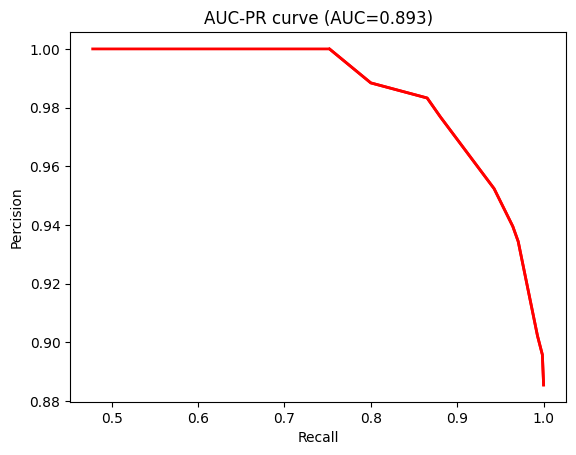



Train Decision Tree with args: min_samples = 2, max_depth = 3
Model accuracy: 0.9705
Model recall: 0.9434
Model percision: 0.9946
Model F1: 0.9683


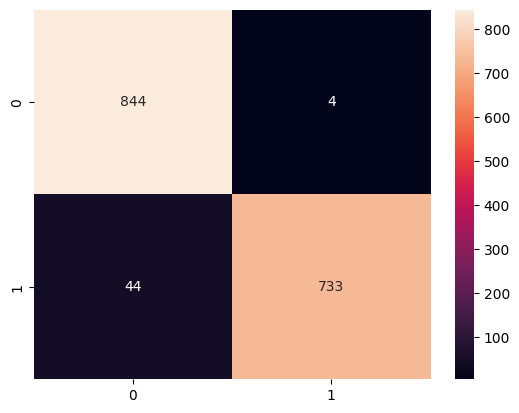

Area under curve=0.9947935637794129


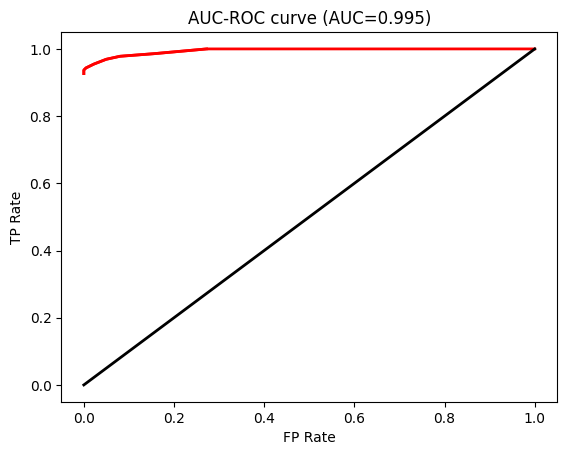

Area under curve=0.9315402977359116


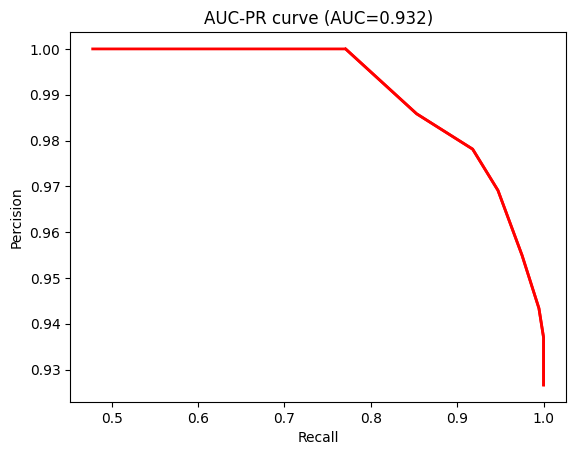



Train Decision Tree with args: min_samples = 2, max_depth = 4
Model accuracy: 0.9705
Model recall: 0.9434
Model percision: 0.9946
Model F1: 0.9683


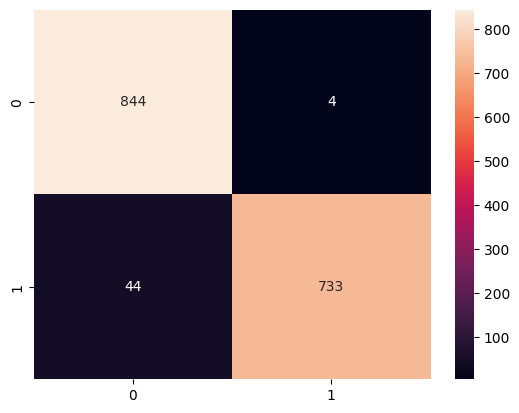

Area under curve=0.9947935637794129


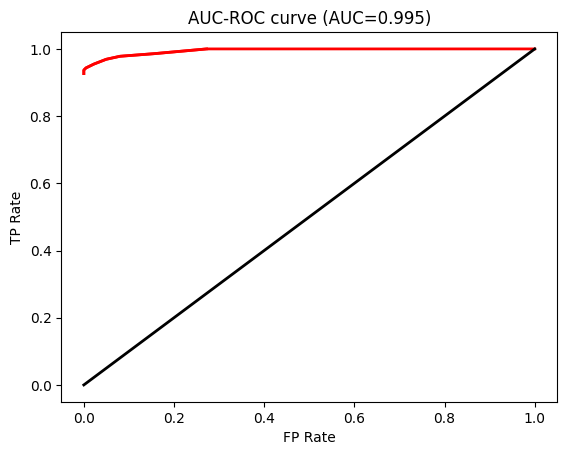

Area under curve=0.9315402977359116


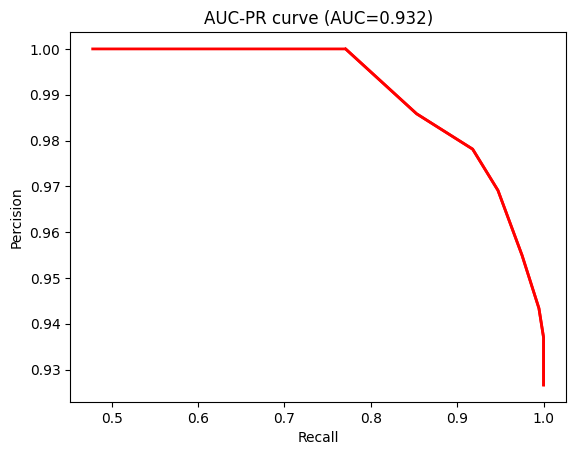



Train Decision Tree with args: min_samples = 2, max_depth = 5
Model accuracy: 0.9705
Model recall: 0.9434
Model percision: 0.9946
Model F1: 0.9683


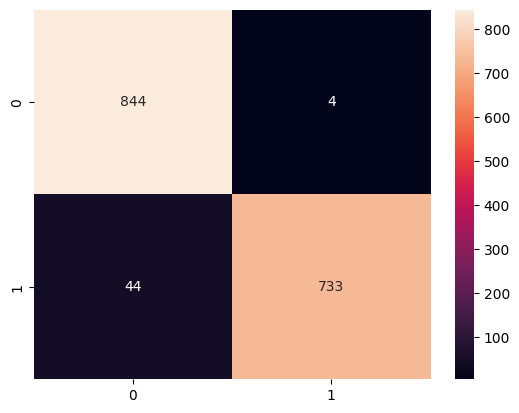

Area under curve=0.9947935637794129


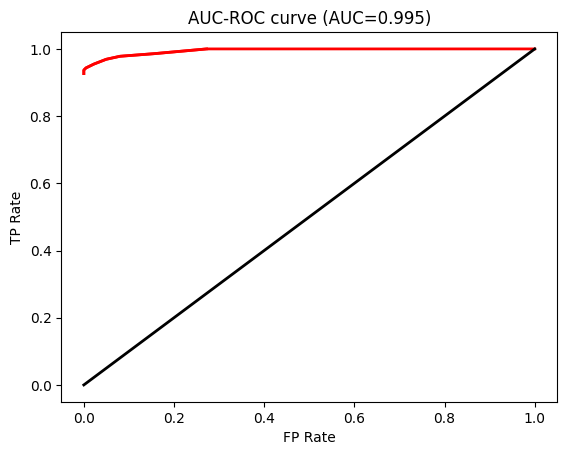

Area under curve=0.9315402977359116


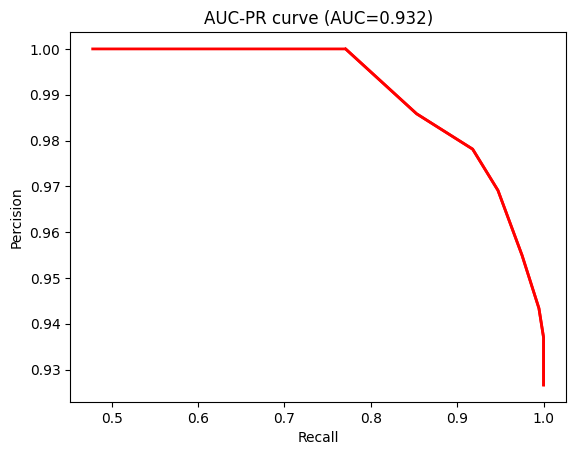



Train Decision Tree with args: min_samples = 3, max_depth = 2
Model accuracy: 0.9502
Model recall: 0.9022
Model percision: 0.9929
Model F1: 0.9454


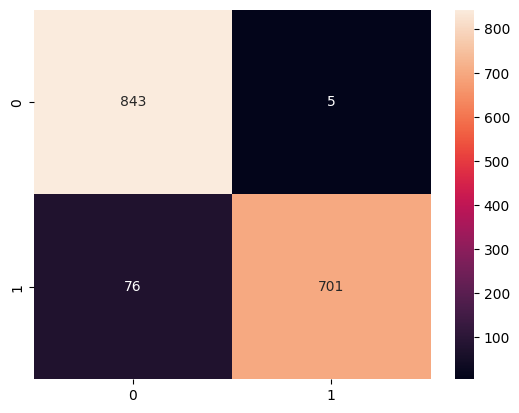

Area under curve=0.9917839841188898


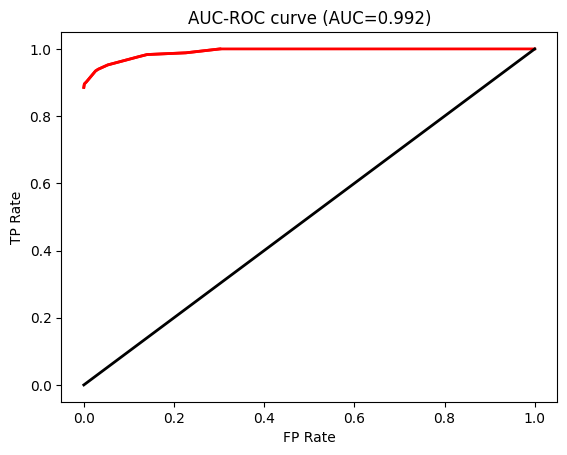

Area under curve=0.8932798416108948


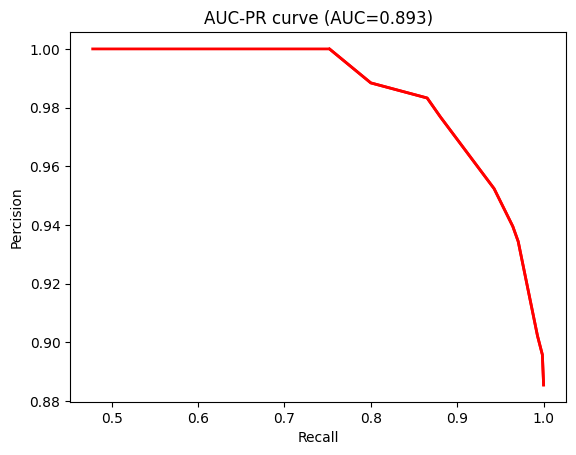



Train Decision Tree with args: min_samples = 3, max_depth = 3
Model accuracy: 0.9705
Model recall: 0.9434
Model percision: 0.9946
Model F1: 0.9683


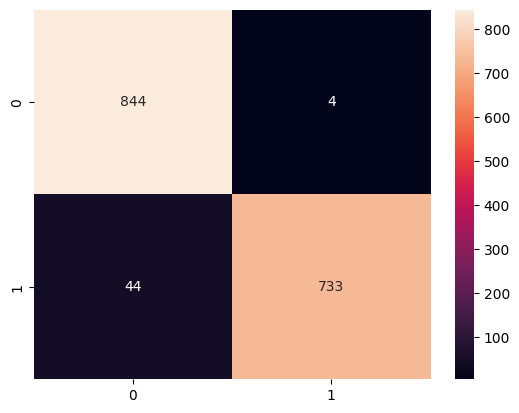

Area under curve=0.9947935637794129


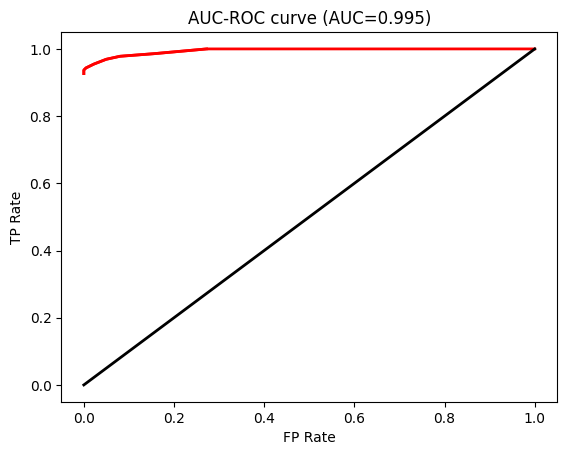

Area under curve=0.9315402977359116


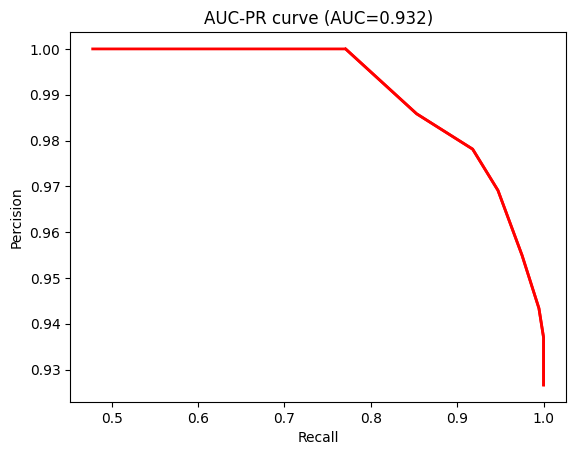



Train Decision Tree with args: min_samples = 3, max_depth = 4
Model accuracy: 0.9705
Model recall: 0.9434
Model percision: 0.9946
Model F1: 0.9683


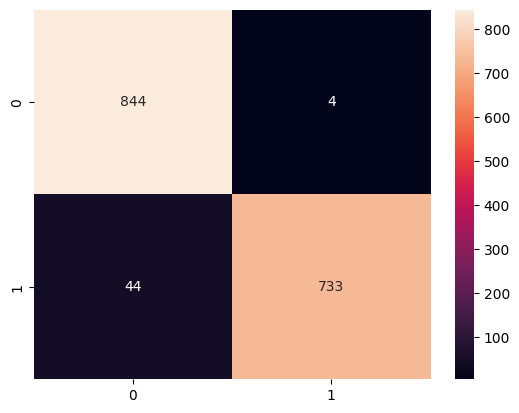

Area under curve=0.9947935637794129


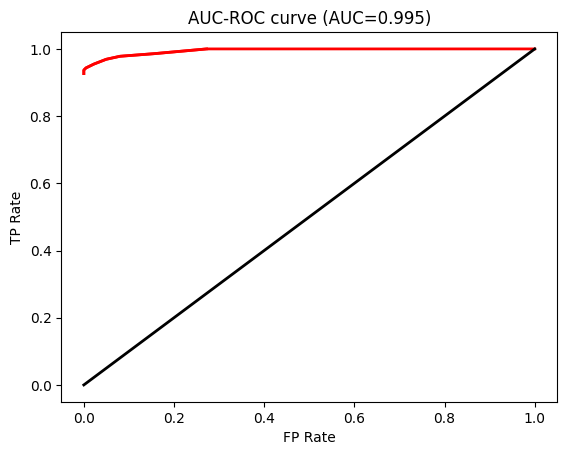

Area under curve=0.9315402977359116


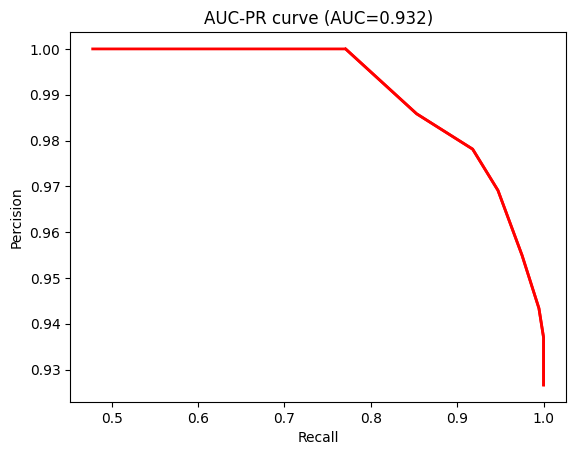



Train Decision Tree with args: min_samples = 3, max_depth = 5
Model accuracy: 0.9705
Model recall: 0.9434
Model percision: 0.9946
Model F1: 0.9683


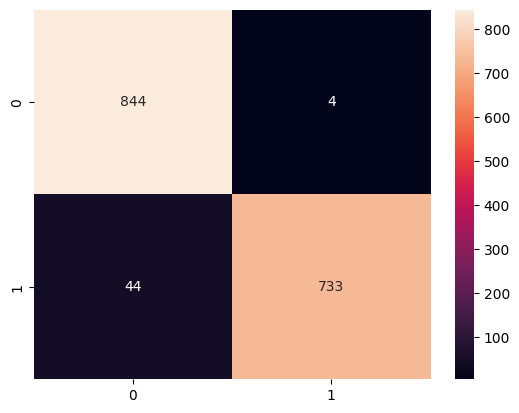

Area under curve=0.9947935637794129


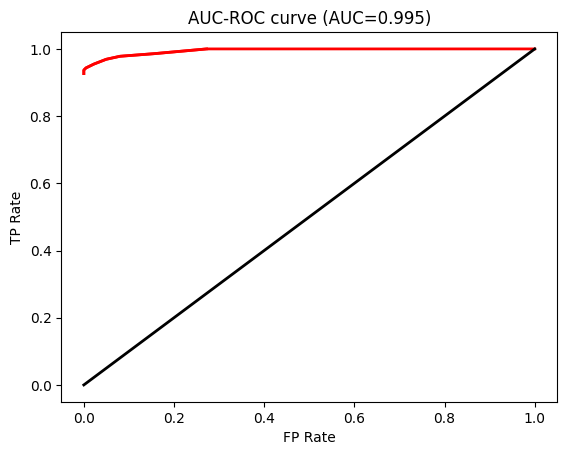

Area under curve=0.9315402977359116


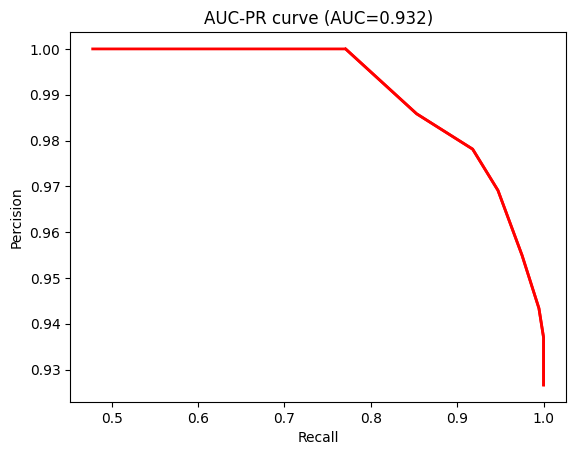



Train Decision Tree with args: min_samples = 4, max_depth = 2
Model accuracy: 0.9502
Model recall: 0.9022
Model percision: 0.9929
Model F1: 0.9454


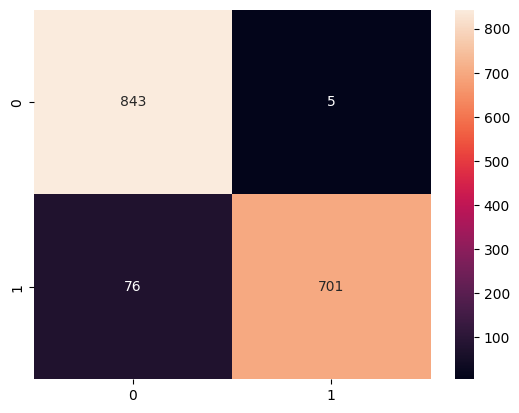

Area under curve=0.9917839841188898


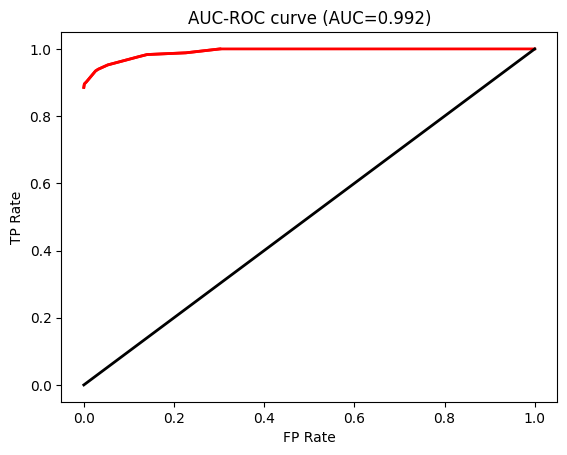

Area under curve=0.8932798416108948


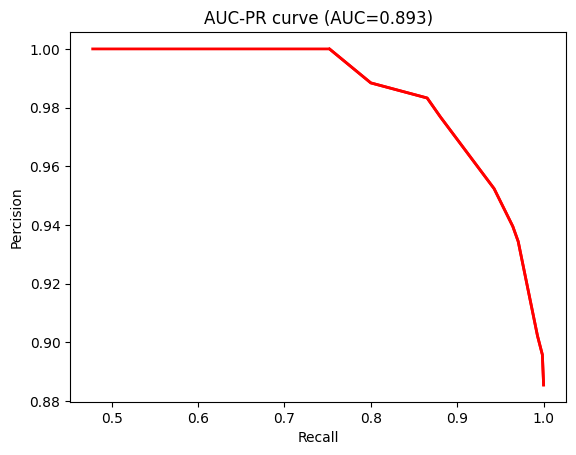



Train Decision Tree with args: min_samples = 4, max_depth = 3
Model accuracy: 0.9705
Model recall: 0.9434
Model percision: 0.9946
Model F1: 0.9683


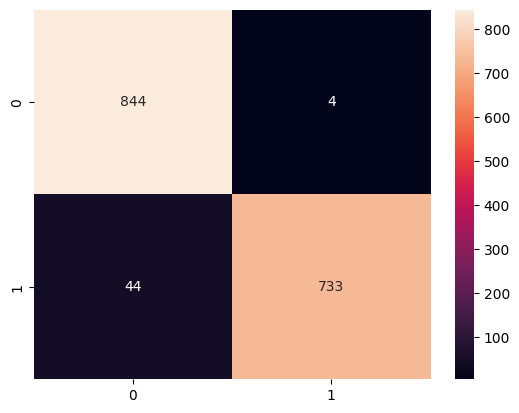

Area under curve=0.9947935637794129


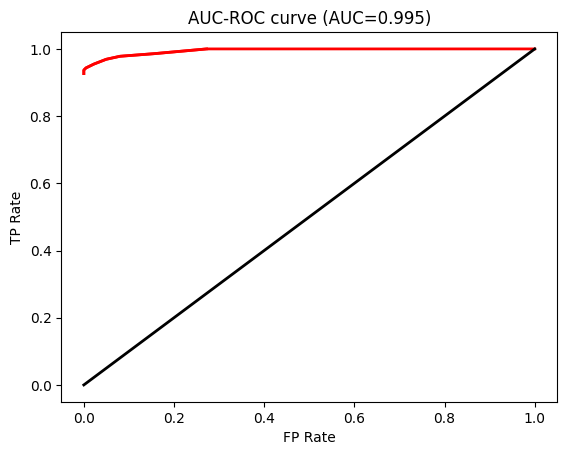

Area under curve=0.9315402977359116


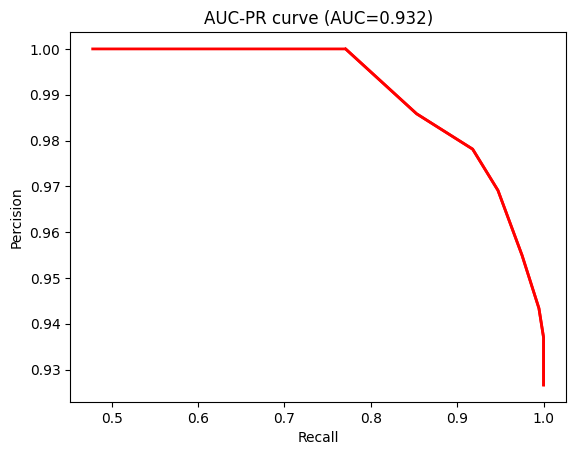



Train Decision Tree with args: min_samples = 4, max_depth = 4
Model accuracy: 0.9705
Model recall: 0.9434
Model percision: 0.9946
Model F1: 0.9683


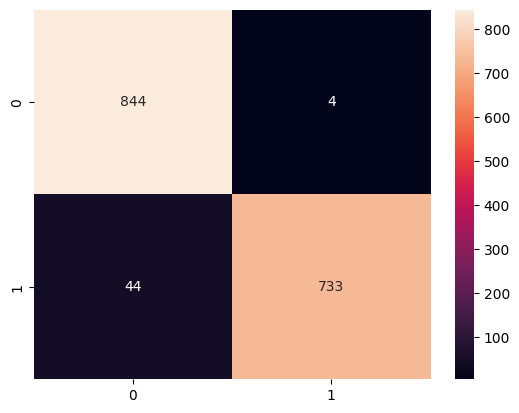

Area under curve=0.9947935637794129


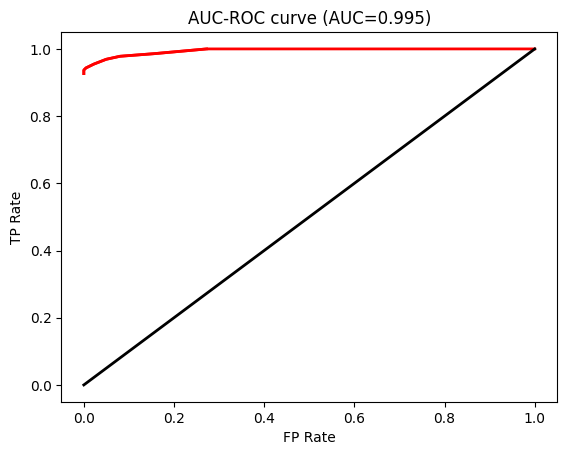

Area under curve=0.9315402977359116


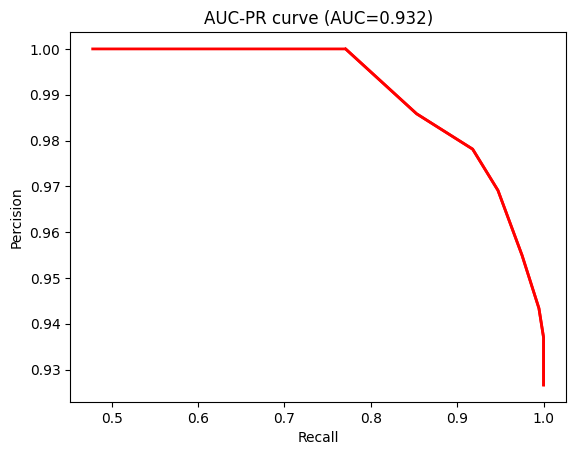



Train Decision Tree with args: min_samples = 4, max_depth = 5
Model accuracy: 0.9705
Model recall: 0.9434
Model percision: 0.9946
Model F1: 0.9683


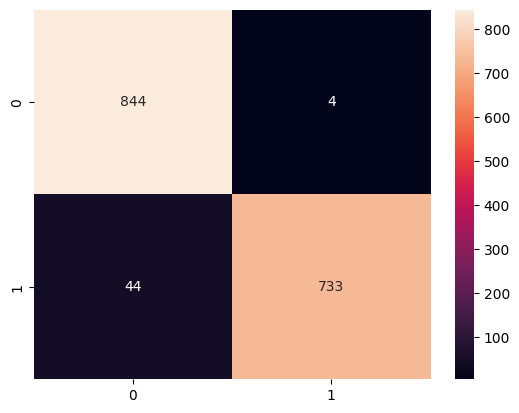

Area under curve=0.9947935637794129


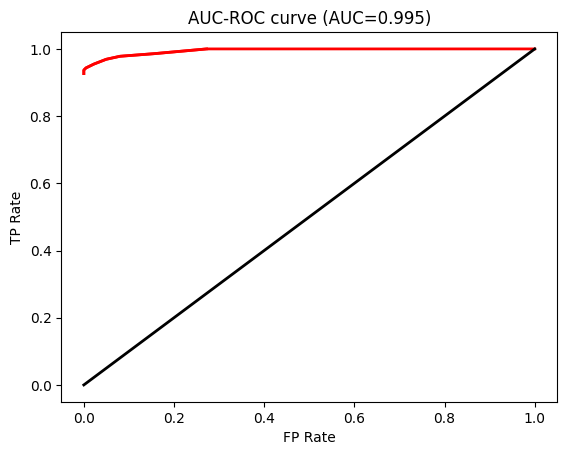

Area under curve=0.9315402977359116


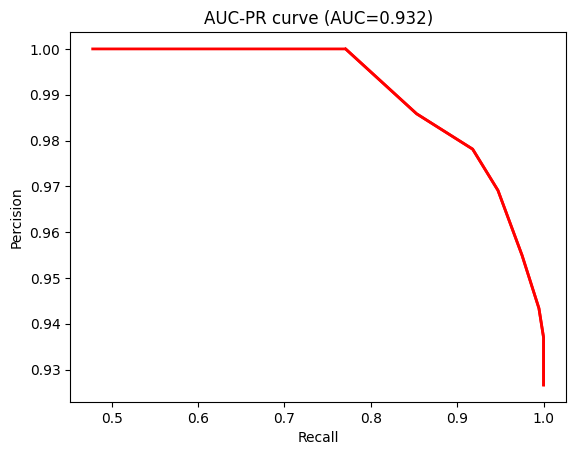

In [ ]:
num_features = round(np.sqrt(len(df.columns) - 1))
features = np.random.choice(len(df.columns) - 1, size=num_features, replace=False)

print("Use features to train:", sorted(features))

best_model = None
best_score = 0

for min_samples in range(2, 5):
    for max_depth in range(2, 6):
        model, score = eval_model(
            df.drop(target_col, axis=1),
            df[target_col],
            features=features,
            min_samples=min_samples,
            max_depth=max_depth
        )

        if score > best_score:
            best_score = score
            best_model = model

        print('\n')

In [ ]:
print("Best model score:", best_score)
print("Best model params:", vars(best_model))

Best model score: 0.9682959048877147
Best model params: {'min_samples': 2, 'max_depth': 3, 'root': <__main__.Node object at 0x7a53f8e00af0>}
